<a href="https://colab.research.google.com/github/devmanas45/VoiceScript/blob/main/Model_A_Z.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [3]:
digits = load_digits()
print("Data shape:", digits.data.shape)  # (1797, 64)


Data shape: (1797, 64)


<Figure size 640x480 with 0 Axes>

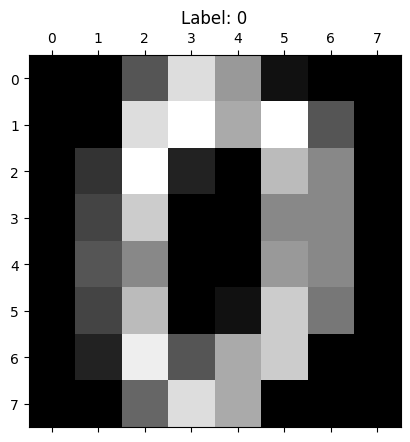

In [4]:
plt.gray()
plt.matshow(digits.images[0])
plt.title(f"Label: {digits.target[0]}")
plt.show()


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    digits.data, digits.target, test_size=0.2, random_state=42
)


In [6]:
model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=10000)

In [7]:
print("Test Accuracy:", model.score(X_test, y_test))


Test Accuracy: 0.975


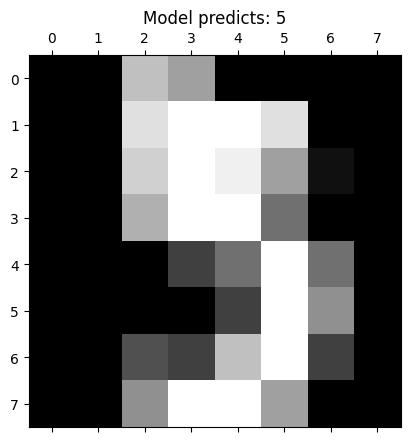

In [8]:
sample_index = 5
plt.matshow(digits.images[sample_index])
plt.title("Model predicts: " + str(model.predict([digits.data[sample_index]])[0]))
plt.show()


In [9]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files


In [43]:


# Upload your handwriting image file (.jpg or .png)
uploaded = files.upload()


Saving 20250415_102622.jpg to 20250415_102622 (1).jpg


In [44]:
image_path = list(uploaded.keys())[0]

# Open and convert to grayscale
img = Image.open(image_path).convert("L")
img_np = np.array(img)

# Apply thresholding (to detect text)
_, thresh = cv2.threshold(img_np, 180, 255, cv2.THRESH_BINARY_INV)

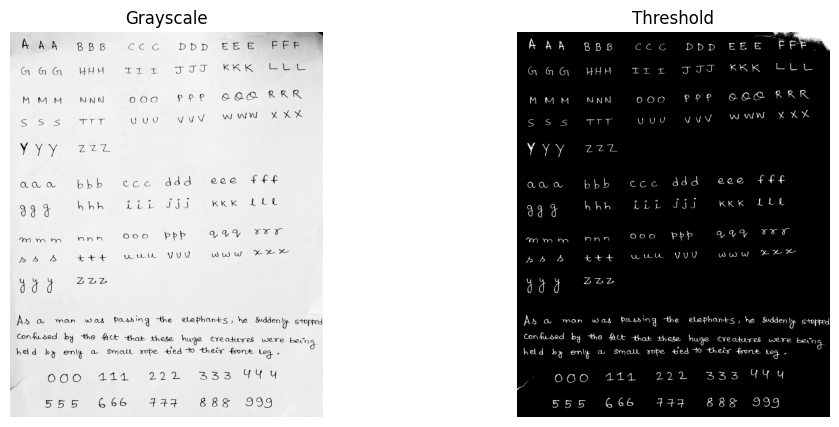

In [45]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Grayscale")
plt.imshow(img_np, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Threshold")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.show()


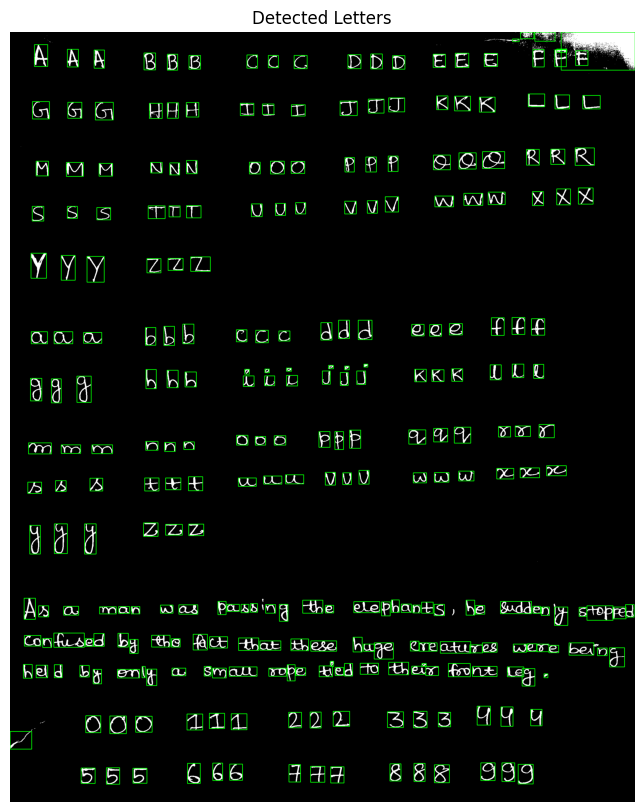

In [46]:
# Make a copy of the thresholded image
thresh_copy = thresh.copy()

# Find contours (blobs of handwriting)
contours, _ = cv2.findContours(thresh_copy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw bounding boxes on a copy
boxed = cv2.cvtColor(thresh_copy, cv2.COLOR_GRAY2BGR)

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    if w > 10 and h > 10:  # filter out small noise
        cv2.rectangle(boxed, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Show result
plt.figure(figsize=(10,10))
plt.imshow(boxed)
plt.title("Detected Letters")
plt.axis('off')
plt.show()


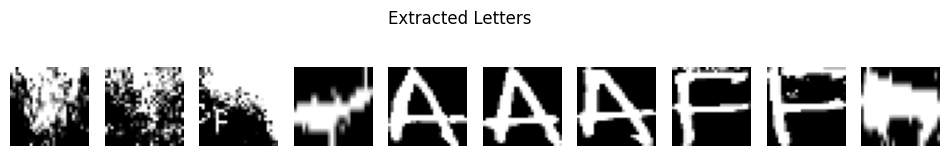

In [47]:
# Sort contours from left to right, top to bottom
bounding_boxes = [cv2.boundingRect(c) for c in contours]
sorted_boxes = sorted(bounding_boxes, key=lambda b: (b[1]//20, b[0]))

letter_images = []

for i, (x, y, w, h) in enumerate(sorted_boxes):
    if w > 10 and h > 10:
        letter = thresh[y:y+h, x:x+w]
        letter = cv2.resize(letter, (28, 28))  # resize for AI training
        letter_images.append(letter)

        # Save if you want
        cv2.imwrite(f"letter_{i}.png", letter)

# Display first 10 letters
plt.figure(figsize=(12, 2))
for i in range(min(10, len(letter_images))):
    plt.subplot(1, 10, i+1)
    plt.imshow(letter_images[i], cmap='gray')
    plt.axis('off')
plt.suptitle("Extracted Letters")
plt.show()


In [48]:
print("Letters detected:", len(letter_images))


Letters detected: 291


In [49]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split


In [50]:
# Convert to numpy arrays
X = np.array(letter_images).reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Dummy labels (A-Z or as many as you have)
num_classes = len(X)
y = np.arange(num_classes)  # labels: 0, 1, 2, ...
y = tf.keras.utils.to_categorical(y, num_classes)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [51]:
# Assuming 'letter_images' already has cropped letters from previous step



model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # one output per class
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 291)            │        37,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 261,283 (1020.64 KB)

 Trainable params: 261,283 (1020.64 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(X_train, y_train, epochs=100, batch_size=8,
                    validation_data=(X_val, y_val))


Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9833 - loss: 0.0212 - val_accuracy: 0.0000e+00 - val_loss: 32.2358
Epoch 2/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 1.0000 - loss: 0.0070 - val_accuracy: 0.0000e+00 - val_loss: 32.6893
Epoch 3/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9911 - loss: 0.0186 - val_accuracy: 0.0000e+00 - val_loss: 33.3742
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9899 - loss: 0.0627 - val_accuracy: 0.0000e+00 - val_loss: 31.2835
Epoch 5/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.0000e+00 - val_loss: 32.3056
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.0000e+00 - val_loss: 33.4535
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.0000e+00 - val_loss: 34.3816
Epoch 8/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.000

In [56]:
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0000e+00 - loss: 54.4673
Validation Accuracy: 0.00%


In [60]:
model.save("handwriting_mimic_model.keras")
